In [227]:
import pandas as pd
import numpy as np

### TODO:
* https://github.com/JosPolfliet/pandas-profiling/issues/25


In [228]:
df = pd.read_csv('train.txt',  sep=';', low_memory=False)
df.columns

Index(['customernumber', 'date', 'salutation', 'title', 'domain',
       'datecreated', 'newsletter', 'model', 'paymenttype', 'deliverytype',
       'invoicepostcode', 'delivpostcode', 'voucher', 'advertisingdatacode',
       'case', 'numberitems', 'gift', 'entry', 'points', 'shippingcosts',
       'deliverydatepromised', 'deliverydatereal', 'weight', 'remi', 'cancel',
       'used', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9',
       'w10', 'target90'],
      dtype='object')

In [229]:
df.head()

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,...,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,...,2,0,0,0,0,0,0,0,0,0


In [230]:
def preprocessing(df):
    df.datecreated = pd.to_datetime(df.datecreated)
    df.date = pd.to_datetime(df.date)
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df.advertisingdatacode.fillna('0', inplace=True)
    df.drop(['delivpostcode', 'entry', 'points', 'deliverydatepromised', 'deliverydatereal', 
            'date', 'datecreated'], inplace=True, axis=1) 
    # dropping this because of cell below, correlated or bad columns
    cols_to_cat = ['advertisingdatacode', 'cancel', 'case', 'deliverytype', 'domain', 'gift', 'invoicepostcode', 
                  'model', 'newsletter', 'numberitems', 'paymenttype', 'remi', 'salutation', 'shippingcosts', 
                  'title']  # it's too much 
    for col in cols_to_cat:
        df[col] = df[col].astype('category').cat.codes

    # for right fitting of estimators
    return df
df = preprocessing(df)
df.target90 = df.target90.replace([0,1], [1, 0])

In [231]:
# Uncomment this to get nice info about the data

# import pandas_profiling
# pandas_profiling.ProfileReport(df).to_file(outputfile="myoutputfile.html")
# import webbrowser
# webbrowser.open('myoutputfile.html')

In [232]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# Uncomment this to get a lot of plots
# sns.pairplot(df).savefig('pair.png')


In [233]:
from sklearn.metrics import confusion_matrix
# we have to minimize type I error in this case
def binary_error(y_pred, train_data):
    matrix = confusion_matrix(train_data.get_label(), y_pred.round())
    return 'error', - matrix[0][1]*10 + matrix[1][1]*3, True

def binary_error_check(y_pred, train_data):
    matrix = confusion_matrix(train_data, y_pred.round())
    return - matrix[0][1]*10 + matrix[1][1]*3

3949


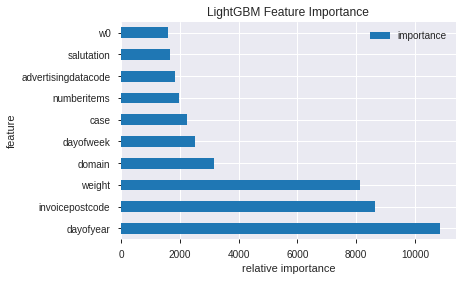

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

train_cols = list(set(df.columns.tolist())-set(['customernumber', 'target90']))
X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df.target90, test_size=0.2, random_state=0)

import lightgbm as lgb

verbose = 1
plot = 1
params = {
#     "max_bin": 1024,
    "learning_rate": 0.1,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':1000,
#     "metric": "auc",
#     "num_leaves": 10,
    "verbose": -1,
#     "min_data": 100,
#     "boost_from_average": True
}

d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=[d_valid], verbose_eval=False, feval=binary_error)
y_pred = model.predict(X_test.values)

# print(roc_auc_score(y_test.values, y_pred))
print(binary_error_check(y_pred ,y_test.values))

df_fi = pd.DataFrame(model.feature_name(), columns=['feature'])
df_fi['importance'] = list(model.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
    plt.title('LightGBM Feature Importance')
    plt.xlabel('relative importance')
    plt.show()

In [194]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
binary_error_check(y_pred, y_test)

('error', 3673, True)

In [200]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train, eval_metric=binary_error)
y_pred = xgb.predict(X_test)
binary_error_check(y_pred, y_test)
# so I can enseble/stack models, but it's test task, so I'll just use LightGBM

('error', 3684, True)

In [226]:
df_test = pd.read_csv('class.txt',  sep=';', low_memory=False)
df_test.columns
df_test = preprocessing(df_test)
df_test.head()
X_test = df_test[train_cols]
cust_numb = df_test['customernumber']
y_pred = model.predict(X_test).round()
with open('submission.csv', 'w+') as f:
#         f.write(first_row + '\n')
        for i in range(cust_numb.shape[0]):
            s = str(cust_numb[i]) + ',' + str(int(y_pred[i]))
            f.write(s + '\n')